# Tohoku tsunami inversion

Try solving the shallow water equations *without* using a mixed space.
Instead, use a vector.

In [1]:
%matplotlib inline

In [2]:
from thetis import *
from firedrake_adjoint import *

In [3]:
import matplotlib.pyplot as plt

In [4]:
from adapt_utils.case_studies.tohoku.options.options import TohokuInversionOptions
from adapt_utils.misc import gaussian, ellipse

In [5]:
def plot_field(field, figure=None, axes=None, height=5, **kwargs):
    CG1 = field.ufl_element().degree() == 1 and field.ufl_element().family() == 'Lagrange'
    fs_constructor = FunctionSpace if len(field.function_space().shape) == 0 else VectorFunctionSpace
    out = field if CG1 else interpolate(field, fs_constructor(field.function_space().mesh(), "CG", 1))
    
    if figure is None and axes is None:
        figure, axes = plt.subplots(figsize=(height*1.2, height))
    if axes is None:
        axes = plt.gca()
    figure.colorbar(tricontourf(out, levels=50, axes=axes, cmap='coolwarm', **kwargs), ax=axes);
    axes.axis(False);
    axes.set_title(field.dat.name);
    return axes

### Forward model

In [6]:
level = 0
op = TohokuInversionOptions(level=level)
gauges = list(op.gauges.keys())
for gauge in gauges:
    if gauge[:2] not in ('P0','80'):
        op.gauges.pop(gauge)
gauges = list(op.gauges.keys())
print(gauges)
op.end_time = 60*30

['801', '802', '803', '804', '806', '807', 'P02', 'P06']


In [7]:
mesh = op.default_mesh
P1DG = FunctionSpace(mesh, VectorElement("DG", triangle, 1, 3))
P1 = FunctionSpace(mesh, "CG", 1)
P0 = FunctionSpace(mesh, "DG", 0)

In [8]:
b = Function(P1).assign(op.set_bathymetry(P1))
g = Constant(op.g)
f = Function(P1).assign(op.set_coriolis(P1))

In [9]:
dtc = Constant(op.dt)
n = FacetNormal(mesh)

q = TrialFunction(P1DG)
u, v, eta = q
xi = TestFunction(P1DG)
phi, psi, zeta = xi

q_ = Function(P1DG)
u_, v_, eta_ = q_

a = inner(q, xi)*dx
L = inner(q_, xi)*dx


def G(uu, vv, elev):
    """
    **HARD-CODED** formulation for vector equal-order LSWE.
    
    Uses the same flux terms as Thetis.
    """
    uv = as_vector([uu, vv])
    uv_test = as_vector([phi, psi])
    hear_star = avg(elev) + sqrt(b/g)*jump(uv, n)
    hu_star = b*(avg(uv) + sqrt(g/b)*jump(elev, n))
    c = sqrt(g*b)
    
    # Gravity
    F = -g*elev*nabla_div(uv_test)*dx
    F += g*hear_star*jump(as_vector([phi, psi]), n)*dS
    F += c*dot(uv, n)*dot(uv_test, n)*ds
    F += 0.5*g*elev*dot(uv_test, n)*ds(100)
    
    # Coriolis
    F += -f*inner(phi, vv)*dx
    F += f*inner(psi, uu)*dx
    
    # HUDiv
    F += -inner(grad(zeta), b*uv)*dx
    F += inner(jump(zeta, n), b*hu_star)*dS
    F += 0.5*zeta*b*dot(uv, n)*ds
    F += zeta*c*elev*ds(100)
    
    return F


a += 0.5*dtc*G(u, v, eta)
L += -0.5*dtc*G(u_, v_, eta_)

q = Function(P1DG)
u, v, eta = q

params = {
    "mat_type": "aij",
    "snes_type": "ksponly",
#     "ksp_type": "gmres",
    "ksp_type": "preonly",
#     "pc_type": "sor",
    "pc_type": "lu",
    "pc_factor_mat_solver_type": "mumps",
}
prob = LinearVariationalProblem(a, L, q)
solver = LinearVariationalSolver(prob, solver_parameters=params)

# Source model

In [10]:
q0 = Function(P1DG)
loc = (0.7e+06, 4.2e+06)
radii = (48e+03, 96e+03)
angle = pi/12
q0.interpolate(as_vector([0, 0, 10*gaussian([loc + radii], mesh, rotation=angle)]))

Coefficient(WithGeometry(FunctionSpace(<firedrake.mesh.MeshTopology object at 0x7f5dc643e908>, VectorElement(FiniteElement('Discontinuous Lagrange', triangle, 1), dim=3), name=None), Mesh(VectorElement(FiniteElement('Lagrange', triangle, 1), dim=2), 1)), 136)

## Forward solve

Now run the forward model, time integrating the QoI as time progresses.

In [11]:
def solve_forward(init):
    q_.assign(init)
    t = 0.0
    J = 0
    iteration = 0
    wq = Constant(0.5)
    eta_obs = Constant(0.0)
    for gauge in gauges:
        op.gauges[gauge]['init'] = None
        if t < op.gauges[gauge]['arrival_time']:
                continue
        op.gauges[gauge]['init'] = q_.at(op.gauges[gauge]['coords'])[2]
        eta_obs.assign(op.gauges[gauge]['init'])
        J = J + assemble(wq*op.gauges[gauge]['indicator']*(q_[2] - eta_obs)**2*dx)
    while t < op.end_time:
        print("t = {:2.0f} mins".format(t/60))

        # Solve forward equation at current timestep
        solver.solve()
        q_.assign(q)
        t += op.dt
        iteration += 1

        # Time integrate QoI
        for gauge in op.gauges:
            if t < op.gauges[gauge]['arrival_time']:
                continue
            elif np.isclose(t, op.gauges[gauge]['arrival_time']):
                wq.assign(0.5*0.5*op.dt)
            elif np.isclose(t, op.gauges[gauge]['departure_time']):
                wq.assign(0.5*0.5*op.dt)
            elif t > op.gauges[gauge]['departure_time']:
                continue
            else:
                wq.assign(0.5*1.0*op.dt)
                
            # Interpolate observations
            if op.gauges[gauge]['init'] is None:
                op.gauges[gauge]['init'] = q.at(op.gauges[gauge]['coords'])[2]
            eta_obs.assign(float(op.gauges[gauge]['interpolator'](t)) + op.gauges[gauge]['init'])

            # Continuous form of error
            J = J + assemble(wq*op.gauges[gauge]['indicator']*(q[2] - eta_obs)**2*dx)

    assert np.allclose(t, op.end_time), "mismatching end time ({:.2f} vs {:.2f})".format(t, op.end_time)
    return J

Define gauge indicators

In [12]:
radius = 20.0e+03*pow(0.5, level)  # The finer the mesh, the more precise the indicator region
for gauge in gauges:
    loc = op.gauges[gauge]["coords"]
    op.gauges[gauge]['indicator'] = interpolate(ellipse([loc + (radius,)], mesh), P0)
    area = assemble(op.gauges[gauge]['indicator']*dx)
    op.gauges[gauge]['indicator'].assign(op.gauges[gauge]['indicator']/area)
    op.sample_timeseries(gauge, sample=op.gauges[gauge]['sample'], detide=True)

In [13]:
J = solve_forward(q0)
print("Quantity of interest = {:.4e}".format(J))

t =  0 mins
t =  1 mins
t =  2 mins
t =  3 mins
t =  4 mins
t =  5 mins
t =  6 mins
t =  7 mins
t =  8 mins
t =  9 mins
t = 10 mins
t = 11 mins
t = 12 mins
t = 13 mins
t = 14 mins
t = 15 mins
t = 16 mins
t = 17 mins
t = 18 mins
t = 19 mins
t = 20 mins
t = 21 mins
t = 22 mins
t = 23 mins
t = 24 mins
t = 25 mins
t = 26 mins
t = 27 mins
t = 28 mins
t = 29 mins
Quantity of interest = 1.9034e+04


<AxesSubplot:title={'center':'Free surface'}>

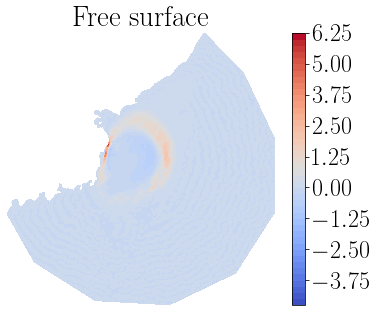

In [14]:
eta = interpolate(q[2], P1)
eta.dat.name = 'Free surface'
plot_field(eta)

## Discrete adjoint

Note that we only Taylor test the elevation and effectively zero out the perturbation away from the source.

In [15]:
c = Control(q0)

In [16]:
stop_annotating();

In [17]:
Jhat = ReducedFunctional(J, c)

In [18]:
np.random.seed(0)
m0 = Function(q0)
dm0 = Function(P1DG)
dm0.dat.data[:] = np.random.rand(*dm0.dat.data.shape)*m0.dat.data
m0 += dm0
minconv = taylor_test(Jhat, m0, dm0)
assert minconv > 1.90, minconv

Running Taylor test
epsilon 1.0000e-02  residual 4.9055e-01
epsilon 5.0000e-03  residual 1.2264e-01
epsilon 2.5000e-03  residual 3.0660e-02
epsilon 1.2500e-03  residual 7.6649e-03
Computed residuals: [0.4905545742376489, 0.12263864053284124, 0.030659661568506635, 0.007664916755970808]
Computed convergence rates: [2.0000000356039407, 1.9999999324619113, 1.9999997432964471]
